This notebook does:
* Run prediction and compare different models
    * Use time-based train/test split (train on 2014-2017, test on 2018 for more realictic results)
    * Models:
        * Simple linear regression: assumes linear relationship, by minimizing squared error.
        * Random forest: average of many independent decision trees. Good for non-linear relationships.
        * LightGBM: gradient boosting, high accuracy and speed on large tabular data.
* Models should be optimized for R2 and RMSE metrics: best is **linear regression** in both.
* Save prediction from best model to given format.

ToDo:
- Fine-tuning of model(s).
- Deal with memory usage! Optimize the model for memory-efficiency (eg. train on random sub-sample), or get more computing capacity for proper calculation.
- Selection of variables (lasso, ridge, elasticnet).


In [2]:
# Load data

df = pd.read_parquet("data/cleaned_df.parquet")
df.head()

,fl_date,origin,dest,crs_dep_time,dep_delay,crs_arr_time,crs_elapsed_time,distance,year,route,...,is_thanksgiving_week,is_xmas_newyear,is_peak_season,weekday,is_weekend,dep_hour,month,season,distance_bin,bank_pressure_hour
0,2014-01-01,DCA,SEA,07:45:00,-12.0,10:37:00,352,2329,2014,DCA-SEA,...,False,True,True,Wednesday,False,7,1,winter,ultra,1
1,2014-01-01,SEA,DCA,14:10:00,-5.0,21:56:00,286,2329,2014,SEA-DCA,...,False,True,True,Wednesday,False,14,1,winter,ultra,9
2,2014-01-01,DCA,SEA,18:40:00,-1.0,21:45:00,365,2329,2014,DCA-SEA,...,False,True,True,Wednesday,False,18,1,winter,ultra,1
3,2014-01-01,SEA,DCA,08:10:00,0.0,16:06:00,296,2329,2014,SEA-DCA,...,False,True,True,Wednesday,False,8,1,winter,ultra,11
4,2014-01-01,EWR,SEA,18:25:00,4.0,21:52:00,387,2402,2014,EWR-SEA,...,False,True,True,Wednesday,False,18,1,winter,ultra,1


In [3]:
df.dtypes

fl_date                   object
origin                  category
dest                    category
crs_dep_time              object
dep_delay                float64
crs_arr_time              object
crs_elapsed_time           int64
distance                   int64
year                       int64
route                     object
is_us_holiday               bool
near_holiday                bool
is_summer_peak              bool
is_thanksgiving_week        bool
is_xmas_newyear             bool
is_peak_season              bool
weekday                   object
is_weekend                  bool
dep_hour                   int64
month                      int32
season                  category
distance_bin            category
bank_pressure_hour         Int64
dtype: object

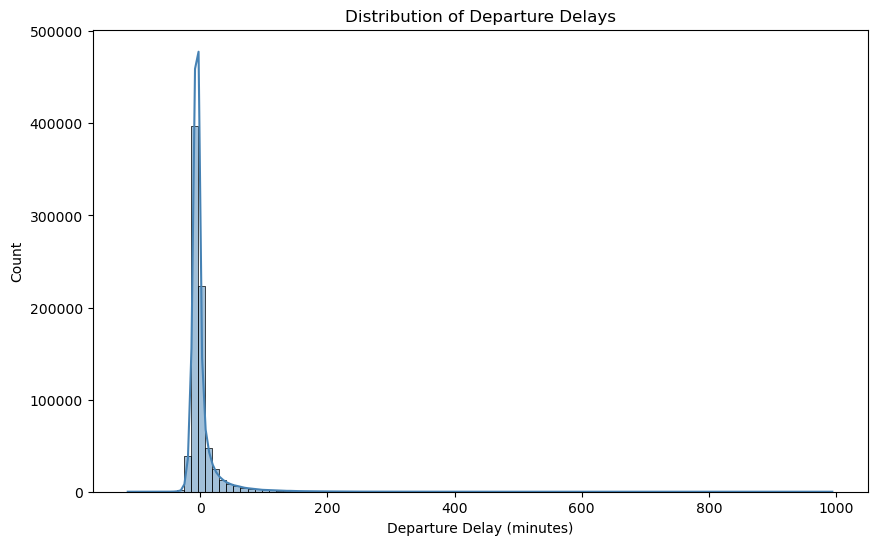

In [10]:

# Histogram + KDE
plt.figure(figsize=(10,6))
sns.histplot(df["dep_delay"].dropna(), bins=100, kde=True, color="steelblue")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Count")
plt.title("Distribution of Departure Delays")
#plt.xlim(-50, 300)   # optional: zoom in (delays can have long tails)
plt.show()

Maybe drop the outlier delays?

In [11]:
n_over_200 = (df["dep_delay"] > 200).sum()
print(f"Number of flights with delay > 200 minutes: {n_over_200}")


Number of flights with delay > 200 minutes: 2091


In [12]:
n_over_0 = (df["dep_delay"] > 0).sum()
print(f"Number of flights with delay > 0 minutes: {n_over_0}")

Number of flights with delay > 0 minutes: 194372


In [ ]:
# =========================
# Baseline comparison: RF vs Linear vs LightGBM
# Train: 2014-2017, Test: 2018-01-01..2018-05-31
# =========================

# ---------- 1) Filter by date range ----------
df = df.copy()
df["fl_date"] = pd.to_datetime(df["fl_date"])

mask_all = (df["fl_date"] >= "2014-01-01") & (df["fl_date"] <= "2018-05-31")
data = df.loc[mask_all].dropna(subset=["dep_delay"]).copy()

# ---------- 2) Features / Target ----------
target = "dep_delay"
features = [
    "origin", "dest", "crs_elapsed_time", "distance", "year", "route",
    "is_us_holiday", "near_holiday", "is_summer_peak",
    "is_thanksgiving_week", "is_xmas_newyear", "is_peak_season",
    "weekday", "is_weekend", "dep_hour", "month", "season",
    "distance_bin", "bank_pressure_hour"
]

# Optional: drop very high-cardinality 'route' to speed things up on a normal PC
DROP_ROUTE = True
if DROP_ROUTE and "route" in features:
    features = [f for f in features if f != "route"]

X = data[features]
y = data[target]

# ---------- 3) Time-based split ----------
train_mask = (data["fl_date"] >= "2014-01-01") & (data["fl_date"] <= "2017-12-31")
test_mask  = (data["fl_date"] >= "2018-01-01") & (data["fl_date"] <= "2018-05-31")

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# ---------- 4) Preprocessing ----------
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "float", "int", "Int64"]).columns.tolist()

# Linear Regression benefits from scaled numeric features; trees don't need scaling
preproc_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

preproc_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

# ---------- 5) Models ----------
rf = Pipeline([
    ("prep", preproc_tree),
    ("rf", RandomForestRegressor(
        n_estimators=50, max_depth=8, n_jobs=-1, random_state=42
    ))
])

lin = Pipeline([
    ("prep", preproc_linear),
    ("lr", LinearRegression())
])

lgbm = Pipeline([
    ("prep", preproc_tree),  # using OHE here for simplicity
    ("lgbm", LGBMRegressor(
        n_estimators=50, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    ))
])

models = {
    "RandomForest": rf,
    "LinearRegression": lin,
    "LightGBM": lgbm
}

# ---------- 6) Train, Predict, Evaluate ----------
def eval_model(name, pipe, Xtr, ytr, Xte, yte):
    pipe.fit(Xtr, ytr)
    y_pred = pipe.predict(Xte)
    mse  = mean_squared_error(yte, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(yte, y_pred)
    print(f"{name:>16} | RMSE: {rmse:8.2f} | R²: {r2:6.3f}")
    return {"model": name, "rmse": rmse, "r2": r2}

results = [eval_model(name, m, X_train, y_train, X_test, y_test) for name, m in models.items()]
results_df = pd.DataFrame(results).sort_values("rmse")
print("\nSorted by RMSE (lower is better):")
print(results_df)


Train: (691659, 18), Test: (89664, 18)
    RandomForest | RMSE:    24.52 | R²:  0.012
LinearRegression | RMSE:    24.35 | R²:  0.025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 691659, number of used features: 177
[LightGBM] [Info] Start training from score 1.595334
        LightGBM | RMSE:    24.39 | R²:  0.022

Sorted by RMSE (lower is better):
              model       rmse        r2
1  LinearRegression  24.348621  0.025163
2          LightGBM  24.391014  0.021766
0      RandomForest  24.516999  0.011634


c:\Users\csoka\anaconda3\envs\myenv310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# =========================
# Predict with best model (LinearRegression) on 2018-06-01..2018-12-31
# =========================

# 1) Define prediction period
pred_mask = (df["fl_date"] >= "2018-06-01") & (df["fl_date"] <= "2018-12-31")
X_pred = df.loc[pred_mask, features]

# 2) Fit LinearRegression on full training window (2014-2017)
lin.fit(X_train, y_train)

# 3) Predict
y_pred = lin.predict(X_pred)

# 4) Build output DataFrame
out = df.loc[pred_mask, ["fl_date", "origin", "dest", "crs_dep_time"]].copy()
out["dep_delay"] = y_pred

# 5) Save to CSV
out.to_csv("output/prediction.csv", index=False)

print("✅ Saved Linear Regression predictions to prediction.csv")
print(out.head())

✅ Saved Linear Regression predictions to prediction.csv
          fl_date origin dest crs_dep_time  dep_delay
785392 2018-06-01    DCA  SEA     08:00:00   1.051024
785393 2018-06-01    SEA  DCA     13:47:00   5.397644
785394 2018-06-01    DCA  SEA     18:55:00   4.253699
785395 2018-06-01    SEA  DCA     08:06:00   3.859824
785396 2018-06-01    JFK  SEA     07:26:00   5.203142
